In [21]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from tqdm import tqdm
from PIL import Image
from datetime import datetime
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay

import matplotlib.pyplot as plt


*Note*: There are some other libraries that may be used to further enhance quality of the code. Some of these are, 

1. ipympl: Enables interactive matplotlib plots in jupyter

# Create Synthetic dataset

Synthetic dataset 1

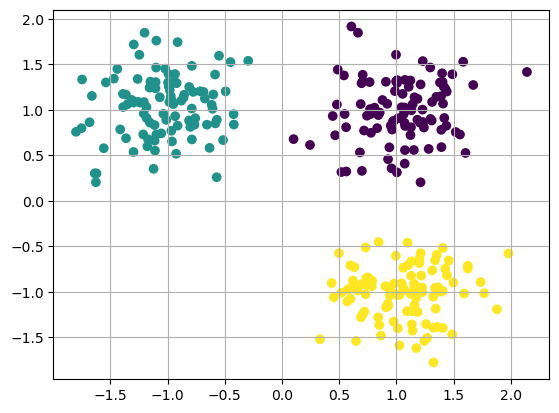

In [22]:
# cluster attributes (means and covariances)
mean1, cov1 = [1,1], [[0.1,0], [0,0.1]]
mean2, cov2 = [-1,1], [[0.1,0], [0,0.1]]
mean3, cov3 = [1, -1], [[0.1, 0], [0, 0.1]]

n = 100 # number of points per cluster

# generate samples
cluster1 = np.random.multivariate_normal(mean1, cov1, n)
cluster2 = np.random.multivariate_normal(mean2, cov2, n)
cluster3 = np.random.multivariate_normal(mean3, cov3, n)

# create dataset by concatenating all the clusters
X = np.vstack([cluster1, cluster2, cluster3]) # input
y = np.array(([0]*n, [1]*n, [2]*n)) # labels
y = y.flatten()

# visualize
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c=y)
ax.grid(True)
plt.show()

# MLP

In [25]:
class AnotherMLP(nn.Module):
    def __init__(self, D_in, H, D_out):
        super(AnotherMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(D_in, H),
            nn.Tanh(),  # nn.ReLU()
            nn.Linear(H, D_out)
        )        
    def forward(self, x):
        y_pred = self.layers(x)
        return y_pred

## Test 1: Check output of a linear layer

Check dtypes

In [26]:
# check data types
fc1 = nn.Linear(2,2)
print("weights are of type ", fc1.weight.dtype)
print("inputs are of type ", X[0,:].dtype)
print("outputs are of type ", y.dtype)

weights are of type  torch.float32
inputs are of type  float64
outputs are of type  int32


In [27]:
# convert to float32
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

print(X.dtype)
print(y.dtype)

torch.float32
torch.int64


In [28]:
print("weights of first layer = ", fc1.weight)
net_act = fc1(X[0,:])
print("output of first layer = ", net_act)

weights of first layer =  Parameter containing:
tensor([[0.7019, 0.0211],
        [0.1000, 0.0946]], requires_grad=True)
output of first layer =  tensor([ 0.4799, -0.3559], grad_fn=<ViewBackward0>)


Put output through nonlinearity

## Test 2: Nonlinearity

In [29]:
LRelu = nn.LeakyReLU()
output = LRelu(net_act)
print("output of LReLu(net_act) = ", output)

output of LReLu(net_act) =  tensor([ 0.4799, -0.0036], grad_fn=<LeakyReluBackward0>)


## Test 3: Output and loss

In [30]:
def my_mse(output_vector, label_vector):
    return torch.mean((output_vector-label_vector)**2)

In [31]:
labels = torch.tensor([1.0, 0.0])
loss_fn = nn.MSELoss()

print(f"Predicted outputs = {output}\nTrue outputs = {labels}\nLoss = ",loss_fn(output, labels))

print("Manually calculated MSE = ", my_mse(output, labels))

Predicted outputs = tensor([ 0.4799, -0.0036], grad_fn=<LeakyReluBackward0>)
True outputs = tensor([1., 0.])
Loss =  tensor(0.1353, grad_fn=<MseLossBackward0>)
Manually calculated MSE =  tensor(0.1353, grad_fn=<MeanBackward0>)


## Create PyTorch Dataset

In [32]:

# create the dataset
dataset = TensorDataset(X, y)

# split the data
train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])

# create dataloaders
shuffle = True
train_loader = DataLoader(train_set, batch_size=10, shuffle=shuffle)
val_loader = DataLoader(val_set, batch_size=10, shuffle=False)

In [33]:
features, labels = next(iter(train_loader))

print("features = ", features)
print("labels = ", labels)

for i, data in enumerate(train_loader):
    print(i)
    features, labels = data
    print(features)

    if i==2:
        break

features =  tensor([[ 0.5417,  1.3794],
        [ 0.7030, -1.2536],
        [ 0.8325,  0.7998],
        [ 1.4276, -0.7463],
        [ 0.6906, -1.2816],
        [ 1.1082,  1.2545],
        [-1.0110,  0.8903],
        [ 1.1957, -0.9829],
        [-1.4389,  1.4505],
        [ 0.8088,  1.0249]])
labels =  tensor([0, 2, 0, 2, 2, 0, 1, 2, 1, 0])
0
tensor([[ 1.1558, -0.9148],
        [ 1.0984, -0.4606],
        [ 1.1419,  1.0615],
        [-0.9493,  1.0641],
        [-1.3627,  0.6882],
        [-0.8604,  1.1339],
        [ 0.7871, -0.8794],
        [ 1.0935, -1.2144],
        [ 1.5843,  1.5296],
        [ 1.1306, -0.6666]])
1
tensor([[-1.6812,  0.8644],
        [ 1.2114,  0.2039],
        [-0.9424,  1.2970],
        [-0.4924,  1.2039],
        [ 1.0046,  0.3136],
        [ 1.0645,  0.9535],
        [ 1.3529, -0.5940],
        [ 1.2602, -1.3554],
        [-0.9918,  1.3955],
        [ 1.5562,  0.7294]])
2
tensor([[-0.9119,  0.8273],
        [ 0.8088,  1.0249],
        [ 0.6958,  1.2934],
      

## Training loop 1

Data in known sequence

In [34]:
net = AnotherMLP(2,2,1)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)



In [35]:
'''Every epoch, we will
    - Perform validation by checking our relative loss on a set of data not used for training
    - Save a copy of the model [1]'''

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
epoch_mean_loss_t = []
epoch_mean_loss_v = []
best_vloss = 1000000.

for epoch in tqdm(range(101)):

    # Part 1 of epoch: Training
    # make sure gradient tracking is on
    net.train(True)

    # initialize training loss and validation loss
    epoch_loss_t = 0.0
    epoch_loss_v = 0.0

    # loop through all batches
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        inputs, labels = data
        outputs = net(inputs)

        # calculate loss
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        # calculate total loss for this epoch
        epoch_loss_t += loss.item()

    # calculate mean loss per batch
    epoch_mean_loss_t.append( epoch_loss_t/(i+1) ) # mean loss per batch this current epoch

    # Part 2 of epoch: Validating
    net.eval()

    # Disable gradient computation to reduce memory consumption
    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            voutputs = net(vinputs)
            vloss = loss_fn(voutputs, vlabels).item()
            epoch_loss_v += vloss
    
    # calculate mean loss per batch (validation set)
    epoch_mean_loss_v.append(epoch_loss_v/(i+1))

    # report losses every 10th epoch
    if epoch % 10 == 0:
        print(f"LOSS train {epoch_mean_loss_t[-1]} valid {epoch_mean_loss_v[-1]}")

    # Track best performance, and save model's state
    if epoch_mean_loss_v[-1] < best_vloss:
        best_vloss = epoch_mean_loss_v[-1]
        model_path = f"models/mlp_{timestamp}_{epoch}"
        torch.save(net.state_dict(), model_path)


fig, ax = plt.subplots()

ax.plot(epoch_mean_loss_t)
ax.plot(epoch_mean_loss_v)
plt.show()



  0%|          | 0/101 [00:00<?, ?it/s]c:\Users\Zayan\anaconda3\envs\nn\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/101 [00:00<?, ?it/s]


RuntimeError: Found dtype Long but expected Float

## Training loop 2

In [ ]:
def train_loop(dataloader_tr, model, loss_fn, optimizer):
    model.train()

    for batch_idx, data in enumerate(dataloader_tr):
        inputs, labels = data
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    # return loss over all batches and number of batches
    return loss.item(), batch_idx+1

def test_loop(dataloader_val, model, loss_fn):
    model.eval()
    
    with torch.no_grad():
        for batch_idx, data in enumerate(dataloader_val):
            inputs, labels = data
            outputs = model(inputs)
            loss = loss_fn(outputs, labels).item()
    
    # return loss over all batches and number of batches
    return loss, batch_idx+1

def eval_classification(model, dataloader_val):
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in dataloader_val:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)

            y_pred.extend(predicted.numpy())
            y_true.extend(labels.numpy())
            correct += (predicted == labels).sum().item()

    # compute metrics
    accuracy = 100 * correct / total
    conf_matrix = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    return accuracy, conf_matrix, f1

In [45]:
# Train and test model
EPOCHS = 100
D_in, H, D_out = 2, 3, 3   
model = AnotherMLP(D_in, H, D_out)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
epoch_mean_loss_tr = []
epoch_mean_loss_v = []

for epoch in range(EPOCHS):

    # training
    training_loss, num_batches_tr = train_loop(dataloader_tr=train_loader,
                                               model=model,
                                               loss_fn=criterion,
                                               optimizer=optimizer)
    
    # validation
    validation_loss, num_batches_v = test_loop(dataloader_val=val_loader,
                                               model=model,
                                               loss_fn=criterion)
    
    epoch_mean_loss_tr.append(training_loss/num_batches_tr)
    epoch_mean_loss_v.append(validation_loss/num_batches_v)
 
 # Evaluate model
accuracy, conf_matrix, f1 = eval_classification(model, val_loader)

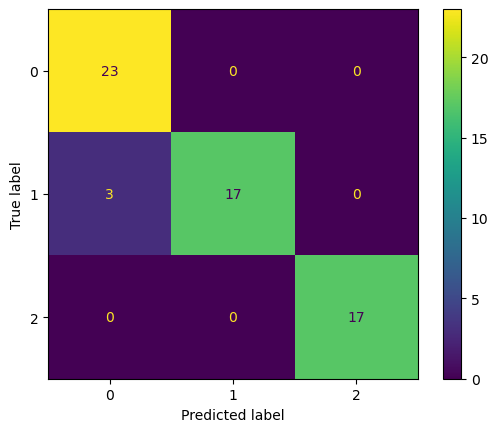

In [46]:
conf_matrix

cm_display = ConfusionMatrixDisplay(conf_matrix).plot()

References

1. https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#dataset-and-dataloader
2. https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

## Chatgpt

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, f1_score

# Step 1: Generate a Synthetic Dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Step 2: Create the MLP Model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Model instance
model = MLP(input_size=2, hidden_size=50, num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 3: Train the Model
num_epochs = 100
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Evaluate the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total

# Step 4: Evaluate the Model - Calculate Confusion Matrix and F1 Score
y_pred = []
y_true = []
for inputs, labels in test_loader:
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    y_pred.extend(predicted.numpy())
    y_true.extend(labels.numpy())

conf_matrix = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')

accuracy, conf_matrix, f1


(100.0,
 array([[63,  0,  0],
        [ 0, 62,  0],
        [ 0,  0, 75]], dtype=int64),
 1.0)

# CNN